# Exemplo de Notebook do Google Collab

Este notebook é apenas um exemplo para a utilização do Google Collab na cadeira de Introdução ao Desenho de Fármacos (módulo de Design Computacional de Fármacos).

Nestes notebooks usa-se a linguagem de programação Python para explorar vários aspectos do Design Computacional de Fármacos. No entanto, a maior parte do código-base encontra-se numa única célula (após a secção "Bases de Python), nas qual estão definidas as funções a usar nos trabalhos práticos. Todos os procedimentos subsequentes são feitos recorrendo apenas a commandos/funções simples.

## Bases de Python

In [2]:
# tudo o que é escrito após o sinal cardinal é um comentário

# podemos usar o python como uma calculadora
2+2

# (usamos Shift-Enter para executar a célula)

4

In [3]:
# Podemos guardar valores em variáveis e usar a função print para escrever o resultado de operações ou o conteúdo de uma variável

pi = 3.14

o_meu_numero = 3

print(pi)
print(2*pi)
print(o_meu_numero * pi + 42)

3.14
6.28
51.42


In [4]:
# Opdemos definir as nossas proprias funções

def somar(x,y):
  resultado = x + y
  return resultado

print(somar(pi,45)) # depois de executar uma célula, as variáveis ficam definidas para as células abaixo!

48.14


In [5]:
# Podemos usar expressões matemáticas imortando os módulos math ou o numpy

import math

print(math.cos(0))
print(math.log(10.0)) # math.log é a função logaritmo natural
print(math.log10(10.0)) # o logaritmo decimal é a math.log10

1.0
2.302585092994046
1.0


In [6]:
# podemos ter uma lista de tudo o que está num módulo com a função dir()
print(dir(math))

['__doc__', '__loader__', '__name__', '__package__', '__spec__', 'acos', 'acosh', 'asin', 'asinh', 'atan', 'atan2', 'atanh', 'ceil', 'copysign', 'cos', 'cosh', 'degrees', 'e', 'erf', 'erfc', 'exp', 'expm1', 'fabs', 'factorial', 'floor', 'fmod', 'frexp', 'fsum', 'gamma', 'gcd', 'hypot', 'inf', 'isclose', 'isfinite', 'isinf', 'isnan', 'ldexp', 'lgamma', 'log', 'log10', 'log1p', 'log2', 'modf', 'nan', 'pi', 'pow', 'radians', 'remainder', 'sin', 'sinh', 'sqrt', 'tan', 'tanh', 'tau', 'trunc']


In [7]:
# Ou escrever um item dessa lista de cada vez, usando um ciclo for
for nome in dir(math):
  print(nome)

__doc__
__loader__
__name__
__package__
__spec__
acos
acosh
asin
asinh
atan
atan2
atanh
ceil
copysign
cos
cosh
degrees
e
erf
erfc
exp
expm1
fabs
factorial
floor
fmod
frexp
fsum
gamma
gcd
hypot
inf
isclose
isfinite
isinf
isnan
ldexp
lgamma
log
log10
log1p
log2
modf
nan
pi
pow
radians
remainder
sin
sinh
sqrt
tan
tanh
tau
trunc


In [8]:
# Finalmente, podemo consultar a documentação de uma dada função, com a função help()
help(math.exp)

Help on built-in function exp in module math:

exp(x, /)
    Return e raised to the power of x.



## Setup

Esta secção tem as definições de funções necessárias para correr as aplicações de química/design de fármacos.

Estas instruções estão divididas em duas células: a primeira faz a instalação do software necessario na máquina remota da Google (demora uns minutos). A segunda célula contém activa os módulos necessários e contém definições de funções necessárias para o trabalho (em geral deverá ser rápida a executar).

É fundamental correr ambas as células, em sequência, para que o resto dos exempos possa correr.

In [1]:
%%capture

! pip install ase
! pip install py3Dmol
! pip install seaborn



!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -y -c rdkit rdkit 
!time conda install -y -c conda-forge openbabel
#!time conda install -y gxx_linux-64
#!time conda install -q -y -c conda-forge rdkit
#!time conda install  -y -c conda-forge xtb

#wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#chmod +x Miniconda3-latest-Linux-x86_64.sh
#bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#conda install  -y -c conda-forge python
#conda install  -y -c conda-forge rdkit
#conda install  -y -c conda-forge xtb
#pip install --user py3Dmol
#pip install --user seaborn

# install XTB
!wget -c https://github.com/grimme-lab/xtb/releases/download/v6.4.0/xtb-210201.tar.xz
!tar xf xtb-210201.tar.xz
!export PATH=/content/xtb-6.4.0/bin:${PATH}
!cd ..



In [2]:
import sys
site_pkg_path='/usr/local/lib/python3.7/site-packages'
if site_pkg_path not in sys.path:
  sys.path.append(site_pkg_path)
import os

import numpy as np
import time
import ase
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDistGeom
IPythonConsole.ipython_3d = True
import py3Dmol
import matplotlib.pyplot as plt
import subprocess
import seaborn as sb

## FUNÇÕES ADMINISTRATIVAS ##

def shell(cmd, shell=True):
  "runs a command in the linux shell, adapted from Jimmy Kromann."
  if shell:
    p = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  else:
    p = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  output, err = p.communicate()
  return output

def run_xtb(args):
  return shell(f"/content/xtb-6.4.0/bin/xtb {args}")

def get_snapshot(dirname='/content/work_dir',fn=None):
  "Downloads work_dir as a tbz file for archive."
  from google.colab import files
  import os
  import time
  origin = os.path.abspath(os.curdir)
  now=time.localtime()
  date_str=f"{now[0]-2000:02d}{now[1]:02d}{now[2]:02d}-{now[3]:02d}{now[4]:02d}"
  ofn = fn if fn else f"{date_str}-{os.path.split(dirname)[-1]}.tbz"
  os.chdir(dirname)
  os.chdir('..')
  shell(f"tar cjf {ofn} ./{os.path.split(dirname)[-1]}")
  files.download(ofn)
  os.chdir(origin)

### Classe Molecule pode ser util para visualizar ficheiros xyz
class Molecule():
  def __init__(self,fn=None, name=None):
    self.name='None'
    self.symbols=list()
    self.geo=np.array([])
    if fn:
      self.read_xyz(fn)
    if name:
      self.name=name

  def natoms(self):
      return len(self.symbols)
  
  def show(self): 
    p = py3Dmol.view(width=400,height=400)
    p.addModel(self.write_xyz())
    #p.setStyle({'stick':{}})
    p.setStyle({'stick':{},'sphere':{'scale':0.3}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    p.show()

  def read_xyz(self, fn):
    "Reads a XYZ file"
    with open(fn,'r') as f:
      data = f.readlines()
    natoms = int(data[0])
    g = list()
    for i in range(2,2+natoms):
      l = data[i].split()
      self.symbols.append(l[0].capitalize())
      g.append(list(map(float,l[1:4])))
    self.geo=np.array(g)

  def centre_location(self):
    "returns the location of the geometrical centre as a vector"
    return self.geo.mean(axis=0)

  def shift(self, displacement):
    "Displaces the molecule as a whole, given a 3D vector (np.array)"
    self.geo += displacement

  def center(self):
    "Displaces the molecule so that its geometrical centre is at the origin."
    self.shift(-self.centre_location())

  def write_xyz(self,fn=None):
    s = f"{self.natoms()}\n Created by Molecule Class\n"
    for n in range(self.natoms()):
        s += f"{self.symbols[n]:3s}"
        for i in range(3):
          s += f" {self.geo[n,i]:16.6f}"
        s += '\n'
    if fn:
      with open(fn,'w') as f:
        f.write(s)
    else:
      return s




## Exemplo de trabalho com o RKit

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

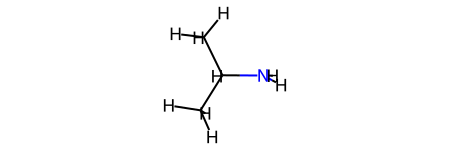

In [3]:
mol=Chem.MolFromSmiles('CC(N)C')
mol=Chem.AddHs(mol)
AllChem.EmbedMolecule(mol,randomSeed=0xf00d)
Chem.MolToMolFile(mol,'test.mol')
mol

## Exemplo de uso do Open babel

In [4]:
# gerar o melhor conformero ao fim de 20 tentativas e de 100 passos de optimização da geometria
!obconformer 20 100 test.mol > best_conf.mol


A T O M   T Y P E S

IDX	TYPE	RING
1	1	NO
2	1	NO
3	8	NO
4	1	NO
5	5	NO
6	5	NO
7	5	NO
8	5	NO
9	23	NO
10	23	NO
11	5	NO
12	5	NO
13	5	NO

F O R M A L   C H A R G E S

IDX	CHARGE
1	0.000000
2	0.000000
3	0.000000
4	0.000000
5	0.000000
6	0.000000
7	0.000000
8	0.000000
9	0.000000
10	0.000000
11	0.000000
12	0.000000
13	0.000000

P A R T I A L   C H A R G E S

IDX	CHARGE
1	0.000000
2	0.270000
3	-0.990000
4	0.000000
5	0.000000
6	0.000000
7	0.000000
8	0.000000
9	0.360000
10	0.360000
11	0.000000
12	0.000000
13	0.000000

S E T T I N G   U P   C A L C U L A T I O N S

SETTING UP BOND CALCULATIONS...
SETTING UP ANGLE & STRETCH-BEND CALCULATIONS...
SETTING UP TORSION CALCULATIONS...
SETTING UP OOP CALCULATIONS...
SETTING UP VAN DER WAALS CALCULATIONS...
SETTING UP ELECTROSTATIC CALCULATIONS...

W E I G H T E D   R O T O R   S E A R C H

  NUMBER OF ROTATABLE BONDS: 0
  NUMBER OF POSSIBLE ROTAMERS: 1
  GENERATED ONLY ONE CONFORMER


C O N J U G A T E   G R A D I E N T S

STEPS = 100

STEP n     E(n)    

In [9]:
!obabel best_conf.mol -O best_conf.xyz

1 molecule converted


In [10]:
!obprop best_conf.mol

name             best_conf.mol 1
formula          C3H9N
mol_weight       59.1103
exact_mass       59.0735
canonical_SMILES CC(N)C	

InChI            InChI=1S/C3H9N/c1-3(2)4/h3H,4H2,1-2H3

num_atoms        13
num_bonds        12
num_residues     0
num_rotors       0
sequence         -
num_rings        0
logP             1.0538
PSA              26.02
MR               19.2424
$$$$


## Exemplo do uso do xTB para optimização da geoemtria

In [14]:
run_xtb(" best_conf.xyz --opt --namespace best_conf-opt  > best_conf-opt.out")

b''

## Exemplo de uso da Classe Molecule para visualização 3D

In [15]:
mymol=Molecule('best_conf-opt.xtbopt.xyz')
mymol.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol